# Fruit and vegetable classification

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruit-and-vegetable-image-recognition


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

In [ ]:
from pathlib import Path

random_path = Path(path) / 'train' / 'apple' / 'Image_1.jpg'

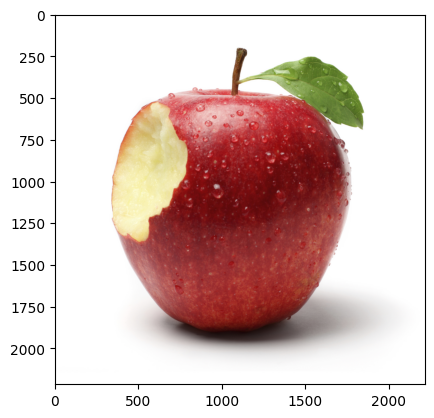

In [ ]:
import cv2

img = cv2.imread(random_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [ ]:
train_dir

PosixPath('/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/train')

In [ ]:
from pathlib import Path

data_dir = Path(path)
train_dir = data_dir / 'train'
valid_dir = data_dir / 'validation'
test_dir = data_dir / 'test'

IMAGE_SIZE = 224
BATCH_SIZE = 16
SEED = 42


augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(-0.025, 0.025)),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomContrast(factor=0.1),
    tf.keras.layers.RandomBrightness(factor = 0.2)
])

rescaling_layers = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])


def augment_layer(image, label):
  return augmentation_layers(image, training=True), label

def rescale_layer(image, label):
  return rescaling_layers(image, training=True), label

def preprocessing_layer(image, label):
  return tf.keras.applications.mobilenet_v2.preprocess_input(image), label


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = SEED,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True,
    crop_to_aspect_ratio = True,
)

classes = train_ds.class_names

train_ds = train_ds\
.cache()\
.map(augment_layer, num_parallel_calls = tf.data.experimental.AUTOTUNE)\
.map(preprocessing_layer, num_parallel_calls = tf.data.experimental.AUTOTUNE)\
.prefetch(tf.data.experimental.AUTOTUNE)


valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    seed = SEED,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False,
    crop_to_aspect_ratio = True,
)\
.map(preprocessing_layer, num_parallel_calls = tf.data.experimental.AUTOTUNE)\
.prefetch(tf.data.experimental.AUTOTUNE)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed = SEED,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False,
    crop_to_aspect_ratio = True
)\
.map(preprocessing_layer, num_parallel_calls = tf.data.experimental.AUTOTUNE)\
.prefetch(tf.data.experimental.AUTOTUNE)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_num = len(classes)
class_num

36

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=7, strides=(2, 2), padding='same',
                    activation='relu', use_bias=False, kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=7, strides=(1, 1), padding='same',
                    activation='relu', use_bias=False, kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2, 2), padding='same',
                    activation='relu', use_bias=False, kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same',
                    activation='relu', use_bias=False, kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),

    tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(2, 2), padding='same',
                    activation='relu', use_bias=False, kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(1, 1), padding='same',
                    activation='relu', use_bias=False, kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation='linear', kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(rate=0.4),

    tf.keras.layers.Dense(units=class_num, activation='softmax', kernel_initializer='glorot_uniform')
])


rlrop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    mode="min",
    min_delta=0.0001,
    min_lr=0.0
)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="min",
    restore_best_weights=False,
)

mcp = tf.keras.callbacks.ModelCheckpoint(
    '/content/my_model.keras',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
)

In [ ]:
my_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = ['accuracy']
)

history = my_model.fit(train_ds, epochs=15,
                       callbacks=[rlrop, es, mcp],
                       validation_data=valid_ds)

Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 623s 3s/step - accuracy: 0.0258 - loss: 3.9431 - val_accuracy: 0.0285 - val_loss: 3.5885 - learning_rate: 0.0100
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 679s 3s/step - accuracy: 0.0269 - loss: 3.6309 - val_accuracy: 0.0285 - val_loss: 3.5881 - learning_rate: 0.0100
Epoch 3/15
183/195 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.0221 - loss: 3.5919

KeyboardInterrupt: 

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print(f'loss: {loss}')
print(f'accuracy: {accuracy}')

15/23 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 2.7778e-04 - loss: 3.6190

KeyboardInterrupt: 

In [ ]:
for images, labels in train_ds.take(1):
  print(image[0])
  print(label[0])
  break

tf.Tensor(
[[[39.527386 39.531937 39.536808]
  [39.527386 39.531937 39.536808]
  [39.528088 39.532642 39.53751 ]
  ...
  [39.52322  39.536102 39.536808]
  [39.52322  39.536102 39.536808]
  [39.52322  39.536102 39.536808]]

 [[39.527386 39.531937 39.536808]
  [39.527386 39.531937 39.536808]
  [39.527386 39.531937 39.536808]
  ...
  [39.52322  39.536102 39.536808]
  [39.52322  39.536102 39.536808]
  [39.52322  39.536102 39.536808]]

 [[39.527386 39.531937 39.536808]
  [39.527386 39.531937 39.536808]
  [39.527386 39.531937 39.536808]
  ...
  [39.52322  39.536102 39.536808]
  [39.52322  39.536102 39.536808]
  [39.52322  39.536102 39.536808]]

 ...

 [[39.53988  39.544434 39.5493  ]
  [39.53988  39.544434 39.5493  ]
  [39.53988  39.544434 39.5493  ]
  ...
  [39.53988  39.544434 39.5493  ]
  [39.53988  39.544434 39.5493  ]
  [39.53988  39.544434 39.5493  ]]

 [[39.53988  39.544434 39.5493  ]
  [39.53988  39.544434 39.5493  ]
  [39.53988  39.544434 39.5493  ]
  ...
  [39.53988  39.544434 39.5

In [ ]:
class_num

36

## Transfer Learning

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

for layer in pretrained_model.layers:
  assert layer.trainable == False



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(class_num, activation='softmax')(x)

new_model = tf.keras.Model(inputs=inputs, outputs=outputs)

new_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# rlrop = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.2,
#     patience=5,
#     mode="min",
#     min_delta=0.0001,
#     min_lr=0.0
# )
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="min",
    restore_best_weights=True,
)

history = new_model.fit(train_ds, epochs=5,
                       callbacks=[es],
                       validation_data=valid_ds)

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.4075 - loss: 2.2420 - val_accuracy: 0.8405 - val_loss: 0.5009
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 154s 790ms/step - accuracy: 0.7915 - loss: 0.5945 - val_accuracy: 0.8575 - val_loss: 0.3995
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 222s 895ms/step - accuracy: 0.8676 - loss: 0.3824 - val_accuracy: 0.9031 - val_loss: 0.3166
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 190s 835ms/step - accuracy: 0.8972 - loss: 0.2735 - val_accuracy: 0.8946 - val_loss: 0.2904
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 216s 907ms/step - accuracy: 0.9244 - loss: 0.2125 - val_accuracy: 0.9345 - val_loss: 0.2799


In [ ]:
loss, accuracy = new_model.evaluate(test_ds)

print(f'loss: {loss}')
print(f'accuracy: {accuracy}')